In [77]:
import matplotlib.pyplot as plt
import numpy as np

X = np.array(([3,5], [5,1], [10,2]), dtype = float)
y = np.array(([75], [82], [93]), dtype = float)

In [5]:
X

array([[ 3.,  5.],
       [ 5.,  1.],
       [10.,  2.]])

In [6]:
y

array([[75.],
       [82.],
       [93.]])

In [78]:
#Normalizing our data

X = X/np.amax(X, axis = 0)

y = y/100

(X,y)

(array([[0.3, 1. ],
        [0.5, 0.2],
        [1. , 0.4]]), array([[0.75],
        [0.82],
        [0.93]]))

In [116]:

class Neural_Network(object):
    def __init__(self):        
        #Define Hyperparameters
        self.inputLayerSize = 2
        self.outputLayerSize = 1
        self.hiddenLayerSize = 3
        
        #Weights (parameters)
        self.W1 = np.random.randn(self.inputLayerSize,self.hiddenLayerSize)
        self.W2 = np.random.randn(self.hiddenLayerSize,self.outputLayerSize)
        
    def forward(self, X):
        #Propogate inputs though network
        self.z2 = np.dot(X, self.W1)
        self.a2 = self.sigmoid(self.z2)
        self.z3 = np.dot(self.a2, self.W2)
        yHat = self.sigmoid(self.z3) 
        return yHat
        
    def sigmoid(self, z):
        #Apply sigmoid activation function to scalar, vector, or matrix
        return 1/(1+np.exp(-z))
    
    def sigmoidPrime(self,z):
        #Gradient of sigmoid
        return np.exp(-z)/((1+np.exp(-z))**2)
    
    def costFunction(self, X, y):
        #Compute cost for given X,y, use weights already stored in class.
        self.yHat = self.forward(X)
        J = 0.5*sum((y-self.yHat)**2)
        return J
        
    def costFunctionPrime(self, X, y):
        #Compute derivative with respect to W and W2 for a given X and y:
        self.yHat = self.forward(X)
        
        delta3 = np.multiply(-(y-self.yHat), self.sigmoidPrime(self.z3))
        dJdW2 = np.dot(self.a2.T, delta3)
        
        delta2 = np.dot(delta3, self.W2.T)*self.sigmoidPrime(self.z2)
        dJdW1 = np.dot(X.T, delta2)  
        
        return dJdW1, dJdW2
    
    #Helper Functions for interacting with other classes:
    def getParams(self):
        #Get W1 and W2 unrolled into vector:
        params = np.concatenate((self.W1.ravel(), self.W2.ravel()))
        return params
    
    def setParams(self, params):
        #Set W1 and W2 using single paramater vector.
        W1_start = 0
        W1_end = self.hiddenLayerSize * self.inputLayerSize
        self.W1 = np.reshape(params[W1_start:W1_end], (self.inputLayerSize , self.hiddenLayerSize))
        W2_end = W1_end + self.hiddenLayerSize*self.outputLayerSize
        self.W2 = np.reshape(params[W1_end:W2_end], (self.hiddenLayerSize, self.outputLayerSize))
        
    def computeGradients(self, X, y):
        dJdW1, dJdW2 = self.costFunctionPrime(X, y)
        return np.concatenate((dJdW1.ravel(), dJdW2.ravel()))
    
    def computeNumericalGradient(self,N, X, y):
        paramsInitial = N.getParams()
        numgrad = np.zeros(paramsInitial.shape)
        perturb = np.zeros(paramsInitial.shape)
        e = 1e-4

        for p in range(len(paramsInitial)):
            #Set perturbation vector
            perturb[p] = e
            N.setParams(paramsInitial + perturb)
            loss2 = N.costFunction(X, y)
            
            N.setParams(paramsInitial - perturb)
            loss1 = N.costFunction(X, y)

            #Compute Numerical Gradient
            numgrad[p] = (loss2 - loss1) / (2*e)

            #Return the value we changed to zero:
            perturb[p] = 0
            
        #Return Params to original value:
        N.setParams(paramsInitial)

        return numgrad

In [79]:
NN = Neural_Network()
yHat = NN.forward(X)

In [80]:
yHat

array([[0.31705474],
       [0.2635287 ],
       [0.33480408]])

In [81]:
cost1 = NN.costFunction(X,y)

dJdW1, dJdW2 = NN.costFunctionPrime(X,y)

In [82]:
dJdW1

array([[-0.08193434,  0.07386948,  0.11260847],
       [-0.06263426,  0.05783949,  0.08140695]])

In [83]:
dJdW2

array([[-0.14968766],
       [-0.19003131],
       [-0.07652238]])

In [87]:
#Gradient Descent
scalar = 3
NN.W1 = NN.W1 - scalar*dJdW1
NN.W2 = NN.W2 - scalar * dJdW2
cost2 = NN.costFunction(X,y)

In [88]:
print(cost1, cost2)

[0.42568005] [0.02924355]


In [117]:
#Numerical Gradient Descent
NN = Neural_Network()
grad = NN.computeGradients(X,y)
numgrad = NN.computeNumericalGradient(NN, X, y)

(grad, numgrad)

(array([-0.01645091,  0.0167155 ,  0.00931036, -0.01261183,  0.01348723,
         0.00839367, -0.13612717, -0.10301376, -0.05225616]),
 array([-0.01645091,  0.0167155 ,  0.00931036, -0.01261183,  0.01348723,
         0.00839367, -0.13612717, -0.10301376, -0.05225616]))

In [119]:
np.linalg.norm(grad - numgrad)/np.linalg.norm(grad + numgrad)

1.1602563258936488e-10

In [130]:
#Training our Network using BFGS optimizer

from scipy import optimize as optim

class trainer(object):
    def __init__(self, N):
        self.N = N
        
    def callbackF(self, params):
        self.N.setParams(params)
        self.J.append(self.N.costFunction(self.X, self.y))
    
    def costFunctionWrapper(self, params, X, y):
        self.N.setParams(params)
        cost = self.N.costFunction(X,y)
        grad = self.N.computeGradients(X,y)
        
        return cost, grad
    
    def train(self, X, y):
        self.X = X;
        self.y = y
        
        self.J = []
        
        params0 = self.N.getParams()
        
        options = {'maxiter': 200, 'disp': True}
        _res = optim.minimize(self.costFunctionWrapper, params0, jac = True, method = 'BFGS',
                                args = (X,y), options = options, callback = self.callbackF)
        
        self.N.setParams(_res.x)
        self.optimizationResults = _res

In [131]:
NN = Neural_Network()
T = trainer(NN)
T.train(X,y)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 49
         Function evaluations: 56
         Gradient evaluations: 56


Text(0, 0.5, 'Cost')

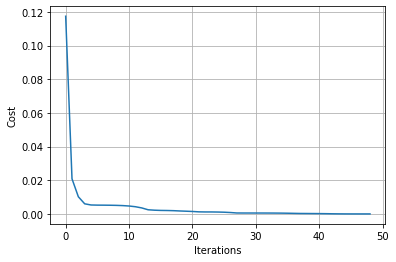

In [132]:
plt.plot(T.J)
plt.grid(1)
plt.xlabel('Iterations')
plt.ylabel('Cost')

In [133]:
NN.costFunctionPrime(X,y)

(array([[ 7.46077967e-07, -2.73790226e-07, -2.67061739e-07],
        [ 8.06393847e-07, -2.61998644e-07, -1.89839019e-07]]),
 array([[9.05865232e-07],
        [5.84486250e-07],
        [1.32867861e-07]]))

In [134]:
NN.forward(X)


array([[0.750003  ],
       [0.82000664],
       [0.93000147]])

In [135]:
y

array([[0.75],
       [0.82],
       [0.93]])

In [144]:
#Testing network for various combinations of sleep/study:
hoursSleep = np.linspace(0,10,100)
hoursStudy =np.linspace(0,5,100)

hoursSleepNorm = hoursSleep/10
hoursStudyNorm = hoursStudy/5

#Creating 2-d versions of input for plotting
a, b = np.meshgrid(hoursSleepNorm, hoursStudyNorm)

#Join it into a single input matrix
allInputs = np.zeros((a.size, 2))
allInputs[:, 0] = a.ravel()
allInputs[:, 1] = b.ravel()

allOutputs = NN.forward(allInputs)

Text(0, 0.5, 'Hours Study')

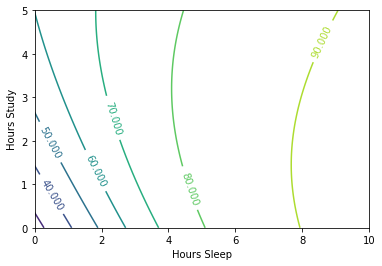

In [147]:
#Plot our graph

yy = np.dot(hoursStudy.reshape(100,1), np.ones((1,100)))
xx = np.dot(hoursSleep.reshape(100,1), np.ones((1,100))).T

CS = plt.contour(xx, yy, 100*allOutputs.reshape(100,100))
plt.clabel(CS, inline = 1, fontsize = 10)
plt.xlabel('Hours Sleep')
plt.ylabel('Hours Study')

Text(0.5, 0, 'Test Score')

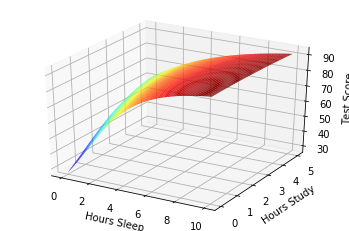

In [149]:
#3D plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.gca(projection = '3d')

surg = ax.plot_surface(xx, yy, 100*allOutputs.reshape(100,100), cmap = plt.cm.jet)

ax.set_xlabel('Hours Sleep')
ax.set_ylabel('Hours Study')
ax.set_zlabel('Test Score')